# Thermal modelling based on a dynamic profile and a power transformer

In this example the following concepts are shown:
*  modelling a power transformer;
*  setting transformer specifications;
*  modelling with a dynamic load and ambient profile;
*  comparing the results, top-oil and hot-spot temperature with temperature limits;
*  calculating paper aging over time according to IEC 60076-7.


Before we start modelling the transformer, we will first import all the required functions and classes.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from transformer_thermal_model.aging import aging_rate_profile, days_aged
from transformer_thermal_model.cooler import CoolerType
from transformer_thermal_model.model import Model
from transformer_thermal_model.schemas import InputProfile, UserTransformerSpecifications
from transformer_thermal_model.transformer import PaperInsulationType, PowerTransformer

## Input profiles

The data, a load profile and an ambient temperature profile, are generated for this example and cover three days. The load is a simple sine with a wavelength of half a day. The ambient temperature is constant over the given period. In the next step they generated and combined into an `InputProfile` object.

*Note that the time series should have the same length and cover the exact same time period.*

*Furthermore, the load and ambient temperature should be formatted as a list, a numpy array or a pandas series.*

In [2]:
datetime_index = [pd.to_datetime("2025-01-01 00:00:00") + pd.Timedelta(minutes=15 * i) for i in np.arange(0, 288)]

load_series = pd.Series(data=np.sin(np.arange(0, 288) * 900 * 2 * np.pi * 1 / 43200) * 500 + 500, index=datetime_index)
ambient_series = pd.Series(data=20, index=datetime_index)

In [3]:
# Create an input object with the profiles
my_profile_input = InputProfile.create(
    datetime_index=datetime_index, load_profile=load_series, ambient_temperature_profile=ambient_series
)

## Transformer object
The next step is to create a power transformer object. We will use a combination of default specifications and user defined specifications. The latter are set via `UserTransformerSpecifications`.

In [4]:
my_transformer_specifications = UserTransformerSpecifications(
    load_loss=160000,  # Transformer load loss [W]
    nom_load_sec_side=1600,  # Transformer nominal current secondary side [A]
    no_load_loss=70000,  # Transformer no-load loss [W]
    amb_temp_surcharge=10,  # Ambient temperature surcharge [K]
    time_const_oil=150,  # Time constant oil [min]
    time_const_windings=7,  # Time constant windings [min]
    top_oil_temp_rise=50.5,  # Top-oil temperature rise [K]
    winding_oil_gradient=23,  # Winding oil gradient (worst case) [K]
    end_temp_reduction=0,  # Lowering of the end temperature with respect to the current specification [K]
    hot_spot_fac=1.2,  # Hot-spot factor [-]
    oil_const_k11=0.5,  # Oil constant k11 [-]
    winding_const_k21=2.0,  # Winding constant k21 [-]
    winding_const_k22=2.0,  # Winding constant k22 [-]
    oil_exp_x=0.8,  # Oil exponent x [-]
    winding_exp_y=1.3,  # Winding exponent x [-]
)
my_transformer = PowerTransformer(user_specs=my_transformer_specifications, cooling_type=CoolerType.ONAF)

## Setup the thermal model and run
Now it is time to create a model based on the transformer and the profiles and run the model to create a temperature profile of the top-oil and the hot-spot.

In [5]:
my_model = Model(temperature_profile=my_profile_input, transformer=my_transformer)

results = my_model.run()

The output, `results`, contains to output profiles: the top-oil temperature profile and the hot-spot temperature profile. They can be accessed using `results.hot_spot_temp_profile` and `results.top_oil_temp_profile`.

In [6]:
print("The first values of the hot-spot temperature profile are:")
print(results.hot_spot_temp_profile.head())

print("And the first values of the top-oil temperature profile are:")
print(results.top_oil_temp_profile.head())

The first values of the hot-spot temperature profile are:
2025-01-01 00:00:00    30.000000
2025-01-01 00:15:00    42.410763
2025-01-01 00:30:00    46.262654
2025-01-01 00:45:00    50.691503
2025-01-01 01:00:00    54.556084
dtype: float64
And the first values of the top-oil temperature profile are:
2025-01-01 00:00:00    30.000000
2025-01-01 00:15:00    34.320281
2025-01-01 00:30:00    38.040463
2025-01-01 00:45:00    41.279628
2025-01-01 01:00:00    44.129399
dtype: float64



Because we did not use an initial temperature, the model sets the initial temperature to the ambient plus the temperature surcharge. When we do not know the actual initial temperatures a period should be cut off. Typically a period of 5 times the oil time constant in minutes is used: `my_transformer.specs.time_const_oil * 5`.  In this period the transformer had enough time to warm up or cool down to match the applied load and ambient temperature.


In [7]:
start_time = datetime_index[0] + pd.Timedelta(my_transformer.specs.time_const_oil * 5, "m")

Now that we have calculated the correct start time we use this to plot the top-oil and hotspot temperature to see how warm our transformer became.

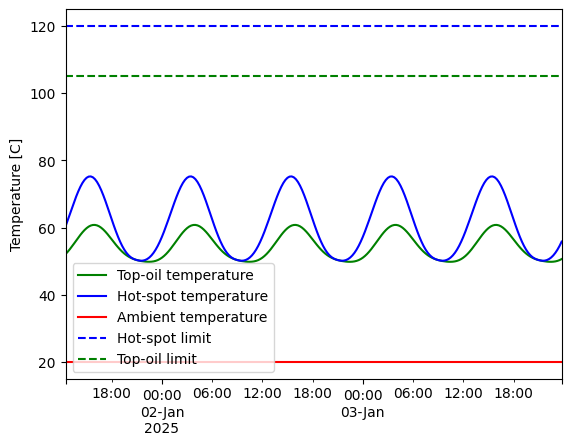

In [8]:
fig = plt.figure()
ax = results.top_oil_temp_profile.loc[start_time::].plot(label="Top-oil temperature", color="green")
results.hot_spot_temp_profile.loc[start_time::].plot(label="Hot-spot temperature", color="blue")
ambient_series.loc[start_time::].plot(label="Ambient temperature", color="red")
ax.set_ylabel("Temperature [C]")
ax.hlines(120, datetime_index[0], datetime_index[-1], linestyles="dashed", label="Hot-spot limit", color="blue")
ax.hlines(105, datetime_index[0], datetime_index[-1], linestyles="dashed", label="Top-oil limit", color="green")
ax.legend(loc="lower left");

We added two more lines in the figure: two limits. These limits show how hot we allow the transformer to become to be used safely and without it to age to much.
You can see that both calculated profiles are nicely below the limits. 

## Paper aging
Now we have seen that the temperature is not too high. We can also have a look at the aging of the transformer. The aging model used is, like the thermal model, also based the Loading Guide. The aging is calculated based on the type of paper insulation (which can be of type `PaperInsulationType.NORMAL` or `PaperInsulationType.TUP`) and the hotspot temperature profile.

Again we cut off the heating period based on five times the oil constant. 

In [9]:
aging_profile = aging_rate_profile(
    hot_spot_profile=results.hot_spot_temp_profile.loc[start_time::],
    insulation_type=PaperInsulationType.NORMAL,
)

In [10]:
total_aging = days_aged(
    hot_spot_profile=results.hot_spot_temp_profile.loc[start_time::],
    insulation_type=PaperInsulationType.NORMAL,
)

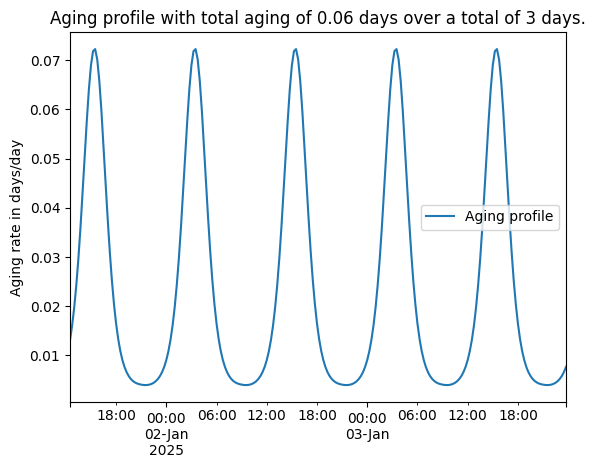

In [ ]:
fig = plt.figure()
ax = aging_profile.plot(label="Aging profile")
ax.set_ylabel("Aging rate in days/day")

ax.legend()
ax.set_title(
    f"Aging profile with total aging of {round(total_aging, 2)} days over a"
    " total of {len(set(aging_profile.index.date))} days."
);